In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-10/: 1


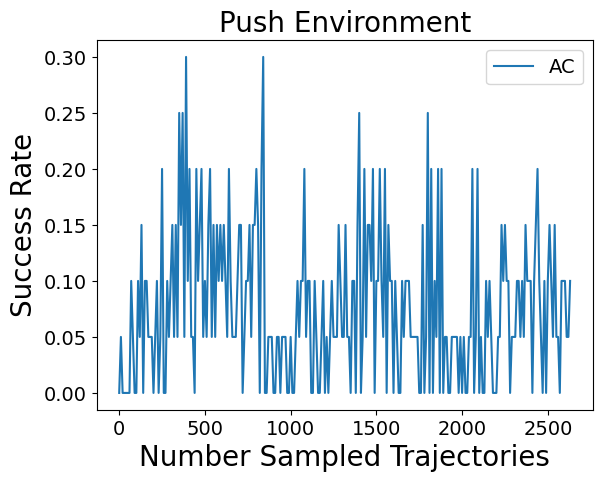

In [22]:
from active_critic.analyze_stats.analyze_stats import make_plot
AC_path_1 = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-10/'
include_AC_1 = ['stats', 'pickplace fast_conv ms 0 training eps: 5000 opt mode: actor+plan demonstrations: 4, im_ph:False, 10, run id: 0']
exlude_AC = ['optimized']


make_plot(
    paths=[AC_path_1], 
    includes=[include_AC_1], 
    excludes=[exlude_AC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=1000
    )


for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-09/: 3
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-04-080_/: 3


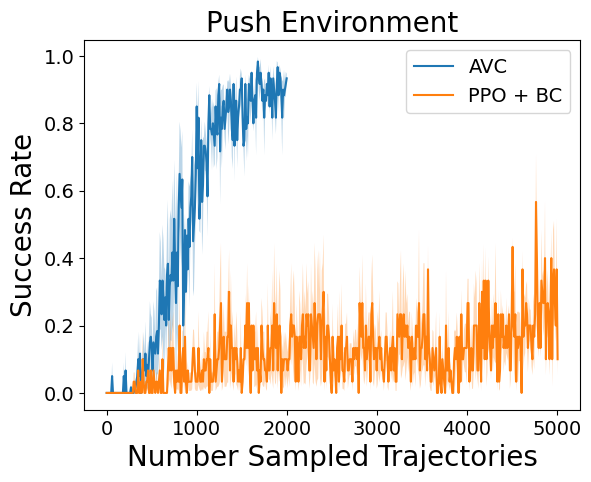

In [20]:
from active_critic.analyze_stats.analyze_stats import make_plot
TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-04-080_/'
include_TQC = ['learner', "TQC_reach_lr_0.00073_demonstrations_0_n_samples_5000"]
exlude_TQC = []

AC_path_1 = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-09/'
include_AC_1 = ['statsoptimized', 'reach ms 5 training eps: 2000 opt mode: actor+plan demonstrations: 0, im_ph:False, 10, run id']
exlude_AC = []

make_plot(
    paths=[AC_path_1, TQC_path], 
    includes=[include_AC_1, include_TQC], 
    excludes=[exlude_AC, exlude_TQC],
    names=['AVC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=False,
    total_plot_points=1000
    )


for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-09/: 3
for path: /data/bing/hendrik/AC_var_2023-04-11/: 1


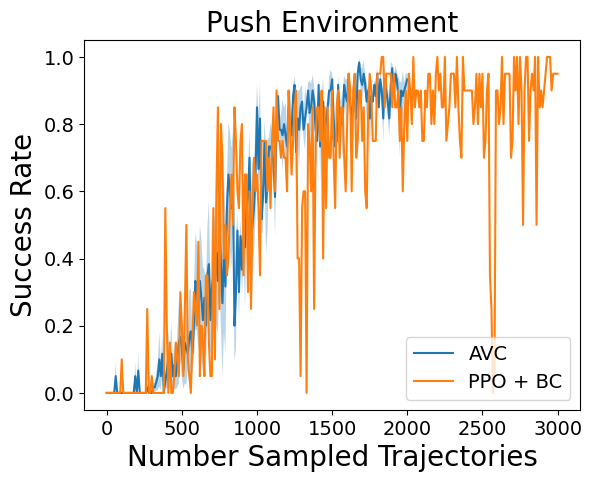

In [19]:
from active_critic.analyze_stats.analyze_stats import make_plot
TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-09'
include_TQC = ['learner', "TQC_reach_lr_0.00073_demonstrations_0_n_samples_5000"]
exlude_TQC = []

AC_path_1 = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-09/'
include_AC_1 = ['statsoptimized', 'reach ms 5 training eps: 2000 opt mode: actor+plan demonstrations: 0, im_ph:False, 10, run id']
exlude_AC = []

AC_path = '/data/bing/hendrik/AC_var_2023-04-11/'
include_AC = ['statsoptimized', 'reach double critic ms 0 training eps: 3000 opt mode: actor+plan demonstrations: 0, im_ph:False, 10, run id: 0']
exlude_AC = []

make_plot(
    paths=[AC_path_1, AC_path], 
    includes=[include_AC_1, include_AC], 
    excludes=[exlude_AC, exlude_AC],
    names=['AVC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=False,
    total_plot_points=1000
    )


In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot


make_plot(
    paths=[AC_path_1], 
    includes=[include_AC_1], 
    excludes=[exlude_AC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=100
    )



In [ ]:
from active_critic.analyze_stats.analyze_stats import plot_actions
AC_path_1 = '/data/bing/hendrik/AC_var_2023-04-11/'
include_AC = ['statsoptimized', 'reach min critic ms 0 training eps: 3000 opt mode: actor+plan demonstrations: 0, im_ph:False, 2, run id: 0']
exlude_AC = []

paths = [AC_path_1]
includes = [include_AC]
excludes = [exlude_AC]

plot_actions(
    paths=paths, 
    includes=includes, 
    excludes=excludes,
    experiment_num=0,
    time_step=1,
    save_path=None,
    legend_fontsize=14,
    label_fontsize=14,
    )

In [ ]:

find_closest = False

abs_file_path_list = []

for i in range(len(paths)):
    abs_file_path_list.append(file_crawler(path=paths[i], substrings=includes[i], exclude=excludes[i]))
dicts = []

for result in abs_file_path_list:
    dicts.append(parse_data(paths=result, find_closest=find_closest))

In [ ]:
plot_actions(dict_list=dicts, experiment_num=0, time_step=3, save_path=None, label_fontsize=16)

In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-10/'
include_AC_1 = ['statsoptimize', 'reach fast_conv ms 0 training eps: 2000 opt mode: actor+plan demonstrations: 0, im_ph:False, 10, run id: 0']
exlude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exlude_AC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=100
    )

In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-04/'
include_AC_1 = ['statsoptimize', 'windowopen high inf lr ms 5 trainin eps: 5000 opt mode: actor+plan demonstrations: 0, im_ph:False, 10, run']
exlude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exlude_AC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=100
    )

In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-04-060_/'
include_TQC = ['learner', 'TQC_reach_lr_0.00073_demonstrations_0_n_samples_5000_id']
exlude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[include_TQC], 
    excludes=[exlude_AC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=100
    )

In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-04-06'
include_AC_1 = ['learner', 'RPPO_pickplace_lr_1e-06_demonstrations_15']
exclude = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=100
    )

In [ ]:
from active_critic.analyze_stats.analyze_stats import make_plot
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-04-06/'
include_AC_1 = ['statsoptimized', 'windowopen ms 0 trainin eps: 5000 opt mode: actor+plan demonstrations: 0, im_ph:False, 10, run id: 1']
exclude = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True,
    total_plot_points=100
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/0331_stats/'
include_AC_1 = ['statsoptimized', 'drawerclose ms 0 explore_until 3 reset drawerclose opt steps: 1 trainin eps: 500 opt mode: actor+plan demonstrations: 0, im_ph:False, training_episodes: 10, min critic: 1e-05, wd: 0.01, val_every: 1000']
exclude_AC = []

TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-04-010_/'
inlcude_TQC = ['learner', 'TQC_pickplace_dense_True_lr_5e-05_demonstrations_4_n_samples_5000_seqlen_100_learning_starts_3000_id_1']
exclude_TQC = []

make_plot(
    paths=[TQC_path], 
    includes=[inlcude_TQC], 
    excludes=[exclude_TQC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/0331_stats/'
include_AC_1 = ['statsoptimized', 'drawerclose ms 0 explore_until 3 reset drawerclose opt steps: 1 trainin eps: 500 opt mode: actor+plan demonstrations: 0, im_ph:False, training_episodes: 10, min critic: 1e-05, wd: 0.01, val_every: 1000']
exclude_AC = []

TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-04-012_/'
inlcude_TQC = ['learner', 'TQC_drawerclose_dense_True_lr_5e-05_demonstrations_0_n_samples_1000_seqlen_100_learning_starts_3000']
exclude_TQC = []

make_plot(
    paths=[TQC_path], 
    includes=[inlcude_TQC], 
    excludes=[exclude_TQC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False,
    find_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-30/'
include_AC_1 = ['statsoptimized', 'reach reinit only positive reach opt steps: 3 trainin eps: 1000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 1e-05, wd: 0.01, val_every: 1000']
exclude_AC = []

PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-30/'
include_PPO = ['PPO_reach_lr_0.0001_demonstrations_1_n_samples_1000', 'learner']
exclude_PPO = []


TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-30/'
include_AC_1 = ['TQC_reach_lr_5e-07_demonstrations_1_n_samples_1000', 'learner']
exclude_TQC = []

make_plot(
    paths=[AC_path, PPO_path, TQC_path], 
    includes=[include_AC_1, include_PPO, include_AC_1], 
    excludes=[exclude_AC, exclude_PPO,exclude_TQC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-30/'
include_AC_1 = ['statsoptimized', 'reach reinit only positive reach opt steps: 3 trainin eps: 1000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 1e-05, wd: 0.01, val_every: 1000']
exclude_AC = []

PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-30/'
include_PPO = ['PPO_windowopen_lr_0.0001_demonstrations_1_n_samples_1000', 'learner']
exclude_PPO = []


TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-30/'
include_AC_1 = ['TQC_windowopen_lr_5e-07_demonstrations_1_n_samples_1000', 'learner']
exclude_TQC = []

make_plot(
    paths=[AC_path, PPO_path, TQC_path], 
    includes=[include_AC_1, include_PPO, include_AC_1], 
    excludes=[exclude_AC, exclude_PPO,exclude_TQC],
    names=['AC', 'PPO + BC', 'TQC + BC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/0329_stats/AC_var_2023-03-29/'
include_AC_1 = ['statsoptimized', 'reach optimize full reach opt steps: 100 trainin eps: 500 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 1e-05, wd: 0.01, val_every: 6000 run id: 0']
exclude_AC = []

AC_path_sparse = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-30/'
include_AC_sparse = ['statsoptimized', 'reach reinit only positive reach opt steps: 3 trainin eps: 1000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 1e-05, wd: 0.01, val_every: 1000']
exclude_AC_sparse = []

make_plot(
    paths=[AC_path, AC_path_sparse], 
    includes=[include_AC_1, include_AC_sparse], 
    excludes=[exclude_AC, exclude_AC_sparse],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/0329_stats/AC_var_2023-03-29/'
include_AC_1 = ['stats', 'pickplace history eps: 5000 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000']
exclude_AC = ['optimized']

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude_AC],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path  = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-30'
include_AC_1 = ['PPO_reach_lr_0.0001_demonstrations_1_n_samples_1000', 'learner']
exclude_TQC = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude_TQC],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-28/'
include_AC_1 = ['TQC_drawerclose_lr_1e-06_demonstrations_0_n_samples_1000', 'learner']
exclude = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-27'

include_AC_1 = ['reach sm manual_seed(2) no train inf eps: 2000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000 ', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude_AC],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-27'

include_RPPO = ['RPPO_push_lr_1e-05_demonstrations_15', 'learner']
exclude_RPPO = []

include_AC_1 = ['TQC_GAIL_push_lr_1e-07_demonstrations_15', 'learner']
exclude_TQC = []

make_plot(
    paths=[bl_path, bl_path], 
    includes=[include_RPPO, include_AC_1], 
    excludes=[exclude_RPPO, exclude_TQC],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25/'

include_AC_1 = ['push 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []


include_AC_non = ['push 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'stats']
exclude_AC_non = ['optimized']

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_AC_1, include_AC_non], 
    excludes=[exclude_AC, exclude_AC_non],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25/'

include_AC_1 = ['pickplace 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC_1], 
    excludes=[exclude_AC],
    names=['AC', 'AC non'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:

AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25/'

include_AC_1 = ['pickplace 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

include_AC_non = ['pickplace 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'stats']
exclude_AC_non = ['optimized']

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_AC_1, include_AC_non], 
    excludes=[exclude_AC,exclude_AC_non],
    names=['AC optimized', 'AC non optimized'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25/'
include_AC_1 = ['TQC_GAIL_pickplace_lr_1e-07_demonstrations_4', 'learner']
exclude_TQC = []

PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24/'
include_PPO = ['PPO_GAIL_pickplace_lr_1e-05_demonstrations_4', 'learner']
exclude_PPO = []


RPPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-05/'
include_RPPO = ['RPPO_pickplace_lr_5e-05_demonstrations_4', 'learner']
exclude_RPPO = []
make_plot(
    paths=[TQC_path, PPO_path, RPPO_path], 
    includes=[include_AC_1, include_PPO, include_RPPO], 
    excludes=[exclude_TQC, exclude_PPO, exclude_RPPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25/'
include_AC_1 = ['TQC_GAIL_push_lr_1e-07_demonstrations_4', 'learner']
exclude_TQC = []

RPPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25/'
include_RPPO = ['RPPO_push_lr_1e-06_demonstrations_4', 'learner']
exclude_RPPO = []

PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24/'
include_PPO = ['PPO_GAIL_push_lr_1e-05_demonstrations_4', 'learner']
exclude_PPO = []

AC_path = '/data/bing/hendrik/AC_var_2023-03-24/'
include_AC_1 = ['push linear critic tiny planner trainin eps: 405 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 15, min critic: 5e-05, wd: 0.1, val_every: 8000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[TQC_path, PPO_path, RPPO_path, AC_path], 
    includes=[include_AC_1, include_PPO, include_RPPO, include_AC_1], 
    excludes=[exclude_TQC, exclude_PPO, exclude_RPPO, exclude_AC],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25/'

include_AC_1 = ['reach 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-26/'
include_PPO = ['PPO_reach_lr_1e-05_demonstrations_1_n_samples_2000', 'learner']
exclude_PPO = []

TQC_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-26/'
include_AC_1 = ['TQC_reach_lr_1e-06_demonstrations_1_n_samples_2000', 'learner']
exclude_TQC = []

RPPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-26/'
include_RPPO = ['RPPO_reach_lr_1e-06_demonstrations_1', 'learner']
exclude_RPPO = []

make_plot(
    paths=[PPO_path, TQC_path, RPPO_path], 
    includes=[include_PPO, include_AC_1, include_RPPO],
    excludes=[exclude_PPO, exclude_TQC, exclude_RPPO],
    names=['AC', 'PPO + BC + GAIL', 'TQC + BC + GAIL', 'RPPO + BC'],
    plot_name='Reach',
    save_path = None,
    plot_closest=False
    )

#PPO_GAIL_windowopen_lr_1e-05_demonstrations_15

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25/'
include = ['pickplace linear critic tiny planner trainin eps: 10000 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 15, min critic: 5e-05, wd: 0.1, val_every: 8000', 'statsoptimized']
exclude = []
make_plot(
    paths=[AC_path], 
    includes=[include], 
    excludes=[exclude],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
ac_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-26'

include_ac = ['reach new plan in inf lin critic eps: 20000 opt mode: actions demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000 run id: 0', 'statsoptimized']
exlude_ac = []
make_plot(
    paths=[ac_path], 
    includes=[include_ac], 
    excludes=[exlude_ac],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
bl_path_PPO = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['TQC_drawerclose_lr_1e-05_demonstrations_0_n_samples_1000_id_0', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path_PPO], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-25/'
AC_path_actions = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22/'

include_Ac = ['reach new plan in inf lin critic eps: 5000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000 run id: 0', 'statsoptimized']
exclude_AC = []

include_Ac_non = ['reach new plan in inf lin critic eps: 5000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000 run id: 0', 'stats']
exclude_AC_non = ['optimized']

include_Ac_actions = ['reach opt mode: actions demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000', 'statsoptimized']
exclude_AC_actions = ['id: 1']

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_Ac, include_Ac_non], 
    excludes=[exclude_AC, exclude_AC_non],
    names=['AC Opt', 'AC non Opt'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22/'

include_Ac = ['reach opt mode: actions demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000', 'statsoptimized']
exclude_AC = ['id: 1']

make_plot(
    paths=[AC_path], 
    includes=[include_Ac], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
bl_path_PPO = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['PPO_drawerclose_lr_1e-05_demonstrations_0_n_samples_1000', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path_PPO], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
bl_path_PPO = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['RPPO_reach_lr_1e-06_demonstrations_4', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path_PPO], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
bl_path_PPO = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['TQC_GAIL_windowopen_lr_1e-07_demonstrations_4', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path_PPO], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )


In [ ]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-23/'

inculde_AC = ['drawerclosereinit tiny planner trainin eps: 200 opt mode: actor+plan demonstrations: 0, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25'

inculde_AC = ['push 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25'

inculde_AC = ['reach 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25'

inculde_AC = ['pickplace 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-24'

inculde_AC = ['windowopenincr incr tiny planner trainin eps: 400 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000 run', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )



In [ ]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-21'
bl_path_PPO = '/data/bing/hendrik/Baselines_Stats_GAIL_2023-03-21'

include_ac_0 = ['stats', 'drawerclose tiny planner trainin eps: 1000 opt mode: actor demonstrations: 0, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 1000']
exclude_ac_0 = ['optimized']

include_TQC_0 = ['learner', 'TQC_drawerclose_lr_1e-06_demonstrations_0_n_samples_20000']
exclude_TQC_0 = []

include_PPO_0 = ['learner', 'PPO_drawerclose_lr_1e-05_demonstrations_0_n_samples_20000']
exclude_PPO_0 = []


make_plot(
    paths=[AC_path, bl_path_PPO, bl_path_PPO], 
    includes=[include_ac_0, include_TQC_0, include_PPO_0], 
    excludes=[exclude_ac_0, exclude_TQC_0, exclude_PPO_0],
    names=['AC Imitation Only', 'AC Reinforcement', 'PPO + GAIL', 'BC + RPPO', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22'

bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-20/'

include_bl_TQC = ['learner', 'TQC_reach_lr_1e-06_demonstrations_4_n_samples_20000_id_0']
exclude_bl_TQC = []

include_bl_PPO = ['learner', 'PPO_reach_lr_1e-05_demonstrations_4_n_samples_20000_id_0']
exclude_bl_PPO = []

include_ac = ['reach tiny planner trainin eps: 20000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 2000', 'stats']
exclude_ac = ['optimize', 'id: 1']

include_ac_opt = ['reach tiny planner trainin eps: 20000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 2000', 'statsoptimize']
exclude_ac_opt = ['id: 1']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, bl_path, bl_path], 
    includes=[include_ac, include_bl_TQC, include_bl_PPO], 
    excludes=[exclude_ac, exclude_bl_TQC, exclude_bl_PPO],
    names=['AC', 'AC Opt', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
import torch as th


In [ ]:
from active_critic.utils.gym_utils import make_policy_dict
pd = make_policy_dict()

In [ ]:
for key in pd:
    print(key)

In [ ]:
PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-20'

include_PPO = ['PPO_reach_lr_1e-05_demonstrations_4_n_samples_20000', 'learner']
exclude_PPO = ['id_1']


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[PPO_path], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24'

include = ['TQC_GAIL_push_lr_5e-07_demonstrations_4_id_range(0, 3)', 'learner']
exclude = []

make_plot(
    paths=[bl_path], 
    includes=[include], 
    excludes=[exclude],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL', 'RPPO + BC'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_Path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-01/'

include_bl = ['pickplace demonstrations: 14, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000', 'stats']
exclude_bl = ['20000']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_Path], 
    includes=[include_bl, include_ac_opt, include_bl], 
    excludes=[exclude_bl, exclude_ac_opt, exclude_bl],
    names=['AC', 'AC Imitation', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'


include_ac = ['push', '20','True', 'stats', '2000']
exclude_ac = ['optimize']

include_ac2 = ['push', '20','False', 'stats', '5000']
exclude_ac2 = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, bl_path], 
    includes=[include_ac, include_ac2, include_bl], 
    excludes=[exclude_ac, exclude_ac2, []],
    names=['AC Imitation', 'AC Reinfocement', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
from active_critic.analyze_stats.push_TQC_PPO_GAIL_5000_10000 import run_exp
run_exp()

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22_val_1000'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac = ['push', '20','True', 'stats']
exclude_ac = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac1 = ['push', '15','False', 'stats']
exclude_ac1 = ['optimize']

include_ac2 = ['push', '15','True', 'stats']
exclude_ac2 = ['optimize']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_ac1, include_ac2], 
    excludes=[exclude_ac1, []],
    names=['AC', 'AC Imitation'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-21'

include_ac = ['pickplace demonstrations: 6, im_ph:False', 'stats']
exclude_ac = ['optimize']

include_bl14 = ['demonstrations_14', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl10 = ['demonstrations_10', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl6 = ['demonstrations_6', 'learner', 'push', 'TQC', 'id_0']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[bl_path, bl_path, bl_path], 
    includes=[include_bl14, include_bl10, include_bl6], 
    excludes=[exclude_bl, exclude_bl, exclude_bl],
    names=['14', '10', '6'],
    plot_name='Push Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/AC/'
PPOGail = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/PPO GAIL'
TQCPath = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/TQC GAIL'

include_ac = ['stats']
exclude_ac = ['optimize']

include_PPOGail = ['learner']
exclude_bl = []

include_TQC = ['learner']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, PPOGail, TQCPath], 
    includes=[include_ac, include_PPOGail, include_TQC], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = None,
    common_steps=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'

include_ac = ['stats', 'window', '6']
exclude_ac = ['optimize']


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path], 
    includes=[include_ac], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None
    )